In [5]:
import joblib
import numpy as np
import pandas as pd
import requests
import shap
from IPython.display import display
from datetime import datetime
import os
import matplotlib.pyplot as plt

In [6]:
model = joblib.load("best_rf_model.pkl")

In [9]:
url = "https://raw.githubusercontent.com/JanisEcker/PraxisProjekt_SAP/main/df_TestData2.csv"

# load csv
response = requests.get(url)
if response.status_code == 200:
    df_TestData = pd.read_csv(url)
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

📂 Speicherordner für kritische Transaktionen: criticalTx\002_20250704_183303
📂 Speicherordner für SHAP Plots: shap_plots\002_20250704_183303
🚨 Gefundene kritische Fälle: 5 von 100
💾 Kritische Transaktionen gespeichert unter: criticalTx\002_20250704_183303\kritische_transaktionen.csv


TypeError: 'numpy.float64' object is not iterable

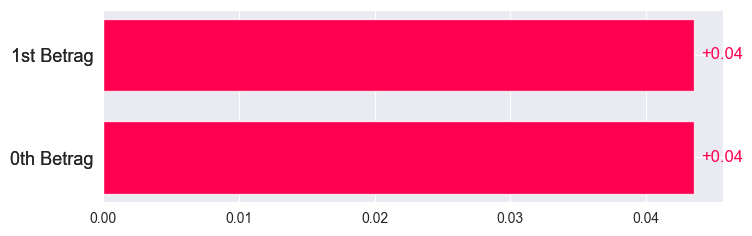

In [10]:
# 0️⃣ Threshold und aktuelle Timestamp definieren
threshold = 0.75
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Fortlaufende Nummer ermitteln
base_folder = "criticalTx"
os.makedirs(base_folder, exist_ok=True)
existing_runs = [name for name in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, name))]
run_numbers = [int(name.split("_")[0]) for name in existing_runs if name.split("_")[0].isdigit()]
next_run_number = max(run_numbers, default=0) + 1

# Run-Foldername generieren
run_folder_name = f"{next_run_number:03d}_{timestamp}"

# Ordner für kritische Transaktionen und SHAP Plots erstellen
kritisch_folder = os.path.join(base_folder, run_folder_name)
os.makedirs(kritisch_folder, exist_ok=True)

shap_folder_base = "shap_plots"
shap_folder = os.path.join(shap_folder_base, run_folder_name)
os.makedirs(shap_folder, exist_ok=True)

print(f"📂 Speicherordner für kritische Transaktionen: {kritisch_folder}")
print(f"📂 Speicherordner für SHAP Plots: {shap_folder}")

# 1️⃣ Features auswählen
feature_columns = [col for col in df_TestData.columns if col != "Fraud"]
X_new = df_TestData[feature_columns]

# 2️⃣ Vorhersagen berechnen
y_pred = model.predict(X_new)
y_proba = model.predict_proba(X_new)[:, 1]

df_TestData["Prediction"] = y_pred
df_TestData["Fraud_Probability"] = y_proba

# 3️⃣ Threshold anwenden
df_TestData["Prediction_custom"] = (df_TestData["Fraud_Probability"] > threshold).astype(int)

# 4️⃣ Kritische Fälle extrahieren
kritische_faelle = df_TestData[df_TestData["Prediction_custom"] == 1]
print(f"🚨 Gefundene kritische Fälle: {len(kritische_faelle)} von {len(df_TestData)}")

# 5️⃣ Kritische Fälle als CSV speichern
kritisch_csv_path = os.path.join(kritisch_folder, "kritische_transaktionen.csv")
kritische_faelle.to_csv(kritisch_csv_path, index=False)
print(f"💾 Kritische Transaktionen gespeichert unter: {kritisch_csv_path}")

# 6️⃣ SHAP-Barplots für kritische Fälle erzeugen und speichern
explainer = shap.Explainer(model)
shap_values = explainer(X_new)

kritisch_idx = kritische_faelle.index

for i in kritisch_idx:
    plt.figure(figsize=(8, 6))
    shap.plots.bar(shap_values[i], show=False)
    plt.title(f"SHAP Barplot – Transaktion {i} (Proba: {df_TestData.loc[i, 'Fraud_Probability']:.2f})")
    plot_path = os.path.join(shap_folder, f"shap_barplot_{i}.png")
    plt.savefig(plot_path, bbox_inches='tight')
    plt.close()
    print(f"✅ SHAP-Plot gespeichert: {plot_path}")

print("✅ Workflow abgeschlossen.")